In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.layers import Lambda
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, ResNet101
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

2024-02-05 01:15:26.840812: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-05 01:15:27.082934: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-05 01:15:27.083032: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-05 01:15:27.129379: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-05 01:15:27.223023: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-05 01:15:27.224331: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
# Constants
DATASET_PATH = "../../data_set"
TRAIN = "Training"
TEST = "Testing"
CLASSES = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]
IMAGE_SIZE = (224, 224)

In [4]:
def load_images_and_labels(dataset_path, train_test, classes):
    data = []
    labels = []
    for class_name in classes:
        class_path = os.path.join(dataset_path, train_test, class_name)
        for filename in os.listdir(class_path):
            try:
                img_path = os.path.join(class_path, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) # Učitavanje as grayscale
                img = cv2.resize(img, IMAGE_SIZE)
                img = np.expand_dims(img, axis=-1)  # Dodavanje dimenzije kanala
                img = img / 255.0  # Normalizacija vrednosti piksela
                data.append(img)
                labels.append(classes.index(class_name))
            except Exception as e:
                print(f"Error loading image {filename}: {e}")
    return np.array(data), np.array(labels)

In [5]:
def create_model(input_shape, num_classes):
    # Load the pre-trained ResNet model
    resnet_model = ResNet101(weights=None, include_top=False, input_shape=(224, 224, 3))
    
    # Prethodno je pokušano sa fine-tuning-om, ali su svi slojevi odmrznuti na kraju
    for layer in resnet_model.layers:
        layer.trainable = True
    
    # Kreiranje novog sekvencijalnog modela
    model = Sequential([
        # Repliciranje sivog kanala u 3 kanala
        Lambda(lambda x: tf.repeat(x, repeats=3, axis=-1), input_shape=input_shape),
        resnet_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        Dense(num_classes, activation='softmax')
    ])

    initial_learning_rate = 0.01
    lr_schedule = ExponentialDecay(
        initial_learning_rate,
        decay_steps=100000,
        decay_rate=0.96,
        staircase=True)

    optimizer = Adam(learning_rate=lr_schedule)

    # Kompajliranje modela
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [6]:
def main():
    # Učitavanje slika i labela   

    data, labels = load_images_and_labels(DATASET_PATH, TRAIN, CLASSES)
    
    # Podela podataka na trening i validacioni skup
    X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)
    
    # Augmentacija podataka
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,    

        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    checkpoint_callback = ModelCheckpoint(
        filepath="run1/weights/weights_epoch_{epoch:02d}_val_accuracy_{val_accuracy:.4f}.h5",
        monitor='val_accuracy',  # Praćenje tačnosti na validacionom skupu
        verbose=1,
        save_best_only=True,  # Čuvanje samo najboljeg modela na osnovu tačnosti na validacionom skupu
        save_weights_only=True,
        mode='max',   
        save_freq='epoch'
       
    )

    # Kreiranje i treniranje modela
    
    model = create_model(IMAGE_SIZE + (1,), len(CLASSES))  # Ensure the input_shape reflects the single channel

    ### Evaluacija ###
    model.load_weights("weights_epoch_26_val_accuracy_0.7787.h5")

    ### Treniranje ###
    # data = model.fit(datagen.flow(X_train, y_train, batch_size=4), epochs=3, validation_data=(X_val, y_val), callbacks=[checkpoint_callback])
    # hist_df = pd.DataFrame(data.history)
    # hist_df.to_excel("run1/training_metrics.xlsx")
    
    # Evaluacija modela na test skupu
    test_data , test_labels = load_images_and_labels(DATASET_PATH, TEST, CLASSES)

    loss, accuracy = model.evaluate(test_data, test_labels)
    print(f"Test accuracy for the current run: {accuracy}")

In [7]:
if __name__ == "__main__":
    main()

13/13 [==============================] - 28s 2s/step - loss: 2.7811 - accuracy: 0.3579
Test accuracy for the current run: 0.3578680157661438


In [8]:
excel_path = "training_metrics.xlsx"
df = pd.read_excel(excel_path)

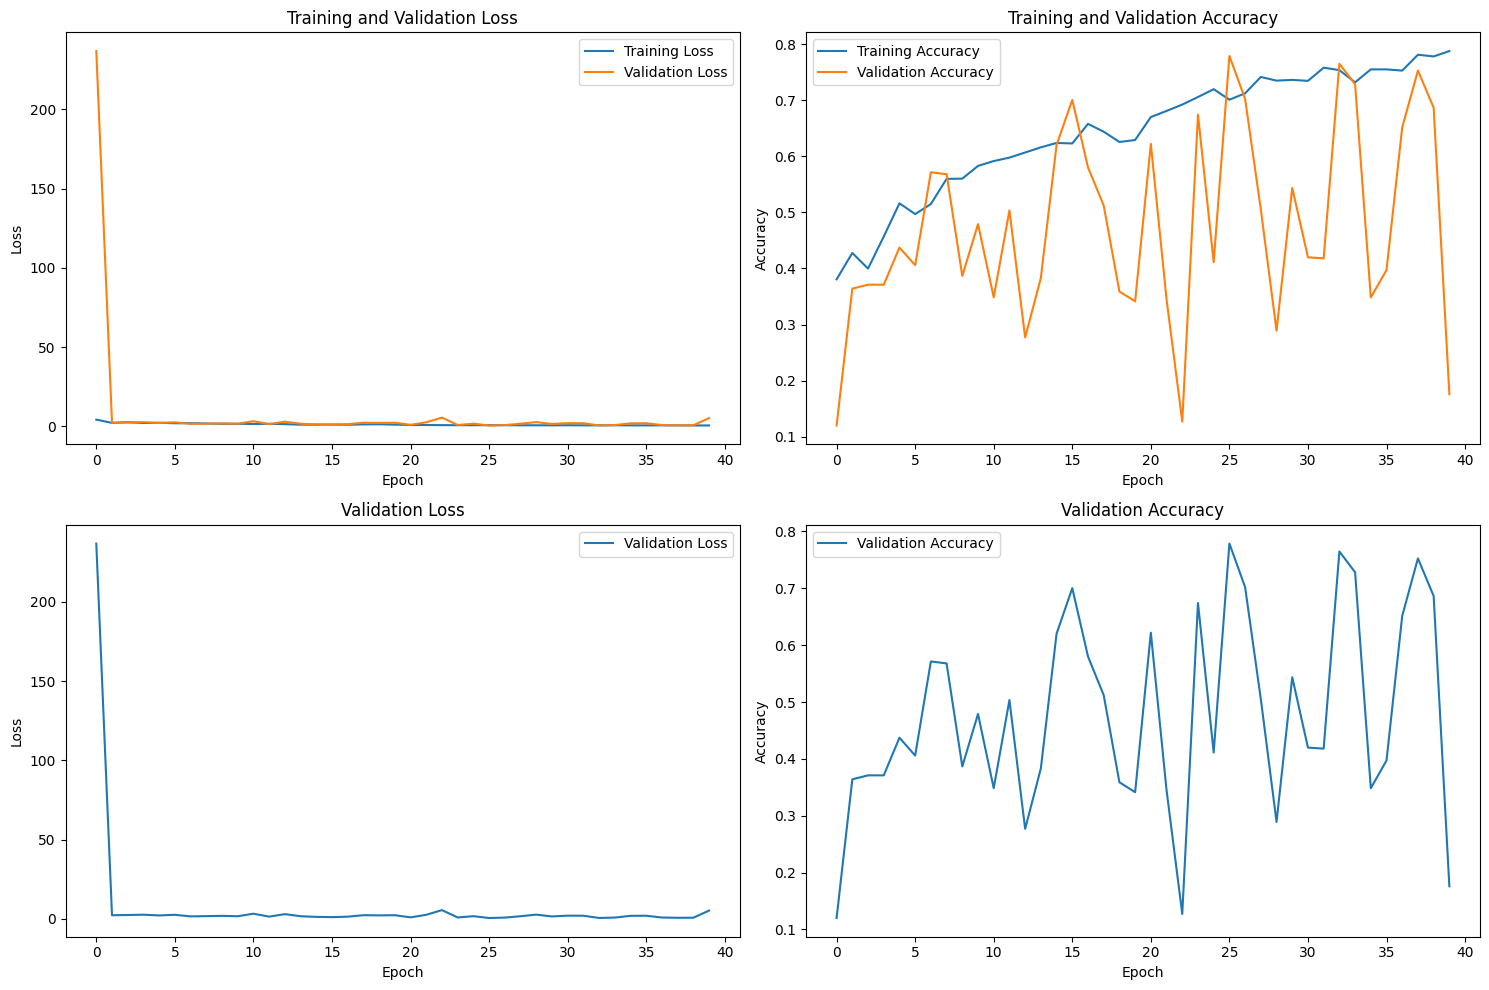

In [9]:
# Plotting
plt.figure(figsize=(15, 10))

# Plot Loss
plt.subplot(2, 2, 1)
plt.plot(df['loss'], label='Training Loss')
plt.plot(df['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(2, 2, 2)
plt.plot(df['accuracy'], label='Training Accuracy')
plt.plot(df['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot another graph (e.g., val_loss and val_accuracy separately)
plt.subplot(2, 2, 3)
plt.plot(df['val_loss'], label='Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(df['val_accuracy'], label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
model = create_model(IMAGE_SIZE + (1,), len(CLASSES))
model.load_weights("weights_epoch_26_val_accuracy_0.7787.h5")

In [11]:
test_data, test_labels = load_images_and_labels(DATASET_PATH, TEST, CLASSES)

In [12]:
predictions = model.predict(test_data)
predicted_labels = np.argmax(predictions, axis=1)

13/13 [==============================] - 28s 2s/step


Matrica konfuzije


In [13]:
conf_matrix = confusion_matrix(test_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[12 26 54  8]
 [ 1 14 95  5]
 [ 2 13 82  8]
 [ 6  4 31 33]]


Classification Report

In [14]:
class_report = classification_report(test_labels, predicted_labels, target_names=CLASSES)
print("Classification Report:")
print(class_report)

Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.57      0.12      0.20       100
meningioma_tumor       0.25      0.12      0.16       115
        no_tumor       0.31      0.78      0.45       105
 pituitary_tumor       0.61      0.45      0.52        74

        accuracy                           0.36       394
       macro avg       0.44      0.37      0.33       394
    weighted avg       0.41      0.36      0.31       394

